# Hospital Services Demand Forecast Using Graph Neural Networks

Big Data Analysis 2024 (Dr. Michael Fire)

Final Project

Tomer Lavi 024158560

## Imports and Setup

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

# Install required packages.
# import os
# os.environ['TORCH'] = torch.__version__
#
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1


In [ ]:
import sqlite3
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, RocCurveDisplay, PrecisionRecallDisplay
import plotly.express as px
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = 'MIMIC'

## Graph Creation

In [ ]:
def get_admissions(anchor_year_group, anchor_year=0, hadm_id=0):
	conn = sqlite3.connect(f'{DATA_PATH}/mimic.db')
	sql = f'''SELECT
          Admissions.hadm_id, admittime, admission_type, admission_location, insurance, language, marital_status, race, gender, anchor_age
          FROM Admissions inner join Patients on Patients.subject_id = Admissions.subject_id
          WHERE anchor_year_group = \'{anchor_year_group}\'
          '''
	if anchor_year > 0:
		sql += f' And anchor_year = {anchor_year}'
	if hadm_id > 0:
		sql += f' And Admissions.hadm_id = {hadm_id}'
	df = pd.read_sql(sql, conn)
	conn.close()
	return df

def get_transfers(anchor_year_group, anchor_year=0, cu_x=('discharge', 'Discharge Lounge'), hadm_id=0):
	conn = sqlite3.connect(f'{DATA_PATH}/mimic.db')
	sql = f'''SELECT
            careunit, Transfers.hadm_id, Transfers.subject_id, intime as transfertime, admission_type, admission_location, insurance, language, marital_status, race, gender, anchor_age
          FROM Transfers Inner Join
	            (Admissions inner join Patients on Patients.subject_id = Admissions.subject_id)
	          on Transfers.hadm_id = Admissions.hadm_id
          WHERE anchor_year_group = \'{anchor_year_group}\'
          '''
	for cu in cu_x:
		sql += f' And Transfers.careunit <> \'{cu}\''
	if anchor_year > 0:
		sql += f' And anchor_year = {anchor_year}'
	if hadm_id > 0:
		sql += f' And Admissions.hadm_id = {hadm_id}'

	sql += ' Order By Transfers.transfer_id'
	df = pd.read_sql(sql, conn)
	conn.close()
	return df

def gen_graph_data(anchor_year_group, anchor_year=0, cu_x=('discharge', 'Discharge Lounge'), hadm_id=0):
    # Load records and create zero based admission and transfer ids to be used as node and edge indexes
    dft = get_transfers(anchor_year_group, anchor_year, cu_x, hadm_id)
    dft['hadm_id'] = dft['hadm_id'].astype('int')
    unique_hadm_ids = dft.sort_values(by='hadm_id').hadm_id.unique()
    unique_hadm_ids = pd.DataFrame(data={'hadm_id': unique_hadm_ids, 'mapped_hadm_id': pd.RangeIndex(len(unique_hadm_ids))})
    dft = pd.merge(dft, unique_hadm_ids, left_on='hadm_id', right_on='hadm_id', how='left')
    unique_careunits = dft.sort_values(by='careunit').careunit.unique()
    unique_careunits = pd.DataFrame(data={'careunit': unique_careunits, 'mapped_careunit': pd.RangeIndex(len(unique_careunits))})
    dft = pd.merge(dft, unique_careunits, left_on='careunit', right_on='careunit', how='left')

    careunits = dft.mapped_careunit.unique()
    admissions = dft.sort_values(by='mapped_hadm_id').mapped_hadm_id.unique()

    dfa = get_admissions(anchor_year_group, anchor_year, hadm_id)
    dfa['hadm_id'] = dfa['hadm_id'].astype('int')
    dfa = pd.merge(dfa, unique_hadm_ids, left_on='hadm_id', right_on='hadm_id', how='left').sort_values(by='mapped_hadm_id')
    X = pd.get_dummies(dfa.drop(columns=['hadm_id', 'admittime', 'mapped_hadm_id']), dtype=float)

    data = HeteroData()
    data['careunit'].node_id = torch.arange(len(careunits))
    data['admission'].node_id = torch.arange(len(admissions))
    data['admission'].x = torch.from_numpy(X.values).to(torch.float)
    data['admission'].time = torch.from_numpy(dfa.admittime.astype('datetime64[s]').astype('int').values)
    data['admission', 'transfer', 'careunit'].edge_index = torch.stack([torch.from_numpy(dft.mapped_hadm_id.values), torch.from_numpy(dft.mapped_careunit.values)], dim=0)
    data['admission', 'transfer', 'careunit'].time = torch.from_numpy(dft.transfertime.astype('datetime64[s]').astype('int').values)
    data = T.ToUndirected()(data)
    return data, dft


data_all, df_all = gen_graph_data('2011 - 2013')
df_all['age10'] = df_all.anchor_age // 10 * 10
df_all

,careunit,hadm_id,subject_id,transfertime,admission_type,admission_location,insurance,language,marital_status,race,gender,anchor_age,mapped_hadm_id,mapped_careunit,age10
0,Cardiac Surgery,21619316,16883140,2180-02-24 17:07:58,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Other,?,MARRIED,HISPANIC/LATINO - DOMINICAN,M,74,16310,0,70
1,Neurology,27072986,10006457,2154-01-29 18:00:34,EU OBSERVATION,WALK-IN/SELF REFERRAL,Other,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,F,57,70483,22,50
2,Transplant,23070905,11441519,2161-03-09 18:48:40,EW EMER.,EMERGENCY ROOM,Other,ENGLISH,MARRIED,WHITE,M,57,30667,32,50
3,Emergency Department,25540031,11615015,2132-10-10 06:36:00,EU OBSERVATION,EMERGENCY ROOM,Medicaid,ENGLISH,SINGLE,WHITE,M,45,55259,5,40
4,Neurology,23215426,17424151,2143-12-21 18:09:13,OBSERVATION ADMIT,PHYSICIAN REFERRAL,Medicare,ENGLISH,WIDOWED,WHITE,F,84,32156,22,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245398,Medicine,28652249,19978766,2165-01-30 15:49:51,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,WIDOWED,OTHER,M,40,86244,16,40
245399,Med/Surg/GYN,28938790,15552483,2186-10-19 18:12:48,EW EMER.,EMERGENCY ROOM,Medicare,ENGLISH,DIVORCED,WHITE,F,82,89042,11,80
245400,Emergency Department,28732749,13716770,2126-12-07 21:51:00,EW EMER.,EMERGENCY ROOM,Medicaid,ENGLISH,SINGLE,WHITE,M,54,87035,5,50
245401,Emergency Department,24287271,18071606,2173-01-22 19:03:00,EU OBSERVATION,EMERGENCY ROOM,Other,?,MARRIED,ASIAN - CHINESE,M,59,42731,5,50


## EDA

In [ ]:
def show_barchart(dfg, split, by, col):
    dfg.sort_values(by=col, inplace=True, ascending=False)
    text = dfg[col].apply(lambda x: '{0:1.2f}%'.format(x))
    title = f'{col} of {by} in each {split}'
    fig = px.bar(dfg, y=split, x=[col], color=by, text=text, labels={'value': '% of class'}, title=title, width=1000, height=1000)
    fig.write_image(f'{DATA_PATH}/Results/{by}-{col}.png')
    fig.show()

def count_cu():
    split = 'careunit'
    dfg = df_all.groupby([split]).size().reset_index()
    dfg.columns = [split, 'Counts']
    title = 'Transfers by Careunit'
    fig = px.bar(dfg, y=split, x='Counts', labels={'Counts': '# of transfers'}, title=title, width=1000, height=1000)
    fig.write_image(f'{DATA_PATH}/Results/CU-Count.png')
    fig.show()

def analyze_cu(by):
    split = 'careunit'
    dfg = df_all.groupby([split, by]).size().reset_index()
    dfg['percentage'] = df_all.groupby([split, by]).size().groupby([split]).apply(lambda x: 100 * x / float(x.sum())).values
    dfg['fraction'] = df_all.groupby([split, by]).size().groupby([by]).apply(lambda x: 100 * x / float(x.sum())).values
    dfg.columns = [split, by, 'Counts', 'Percentage', 'Fraction']

    show_barchart(dfg, split, by, 'Percentage')
    show_barchart(dfg, split, by, 'Fraction')

for col in ['gender', 'admission_type', 'admission_location', 'insurance', 'language', 'marital_status', 'race', 'age10']:
    analyze_cu(col)
count_cu()

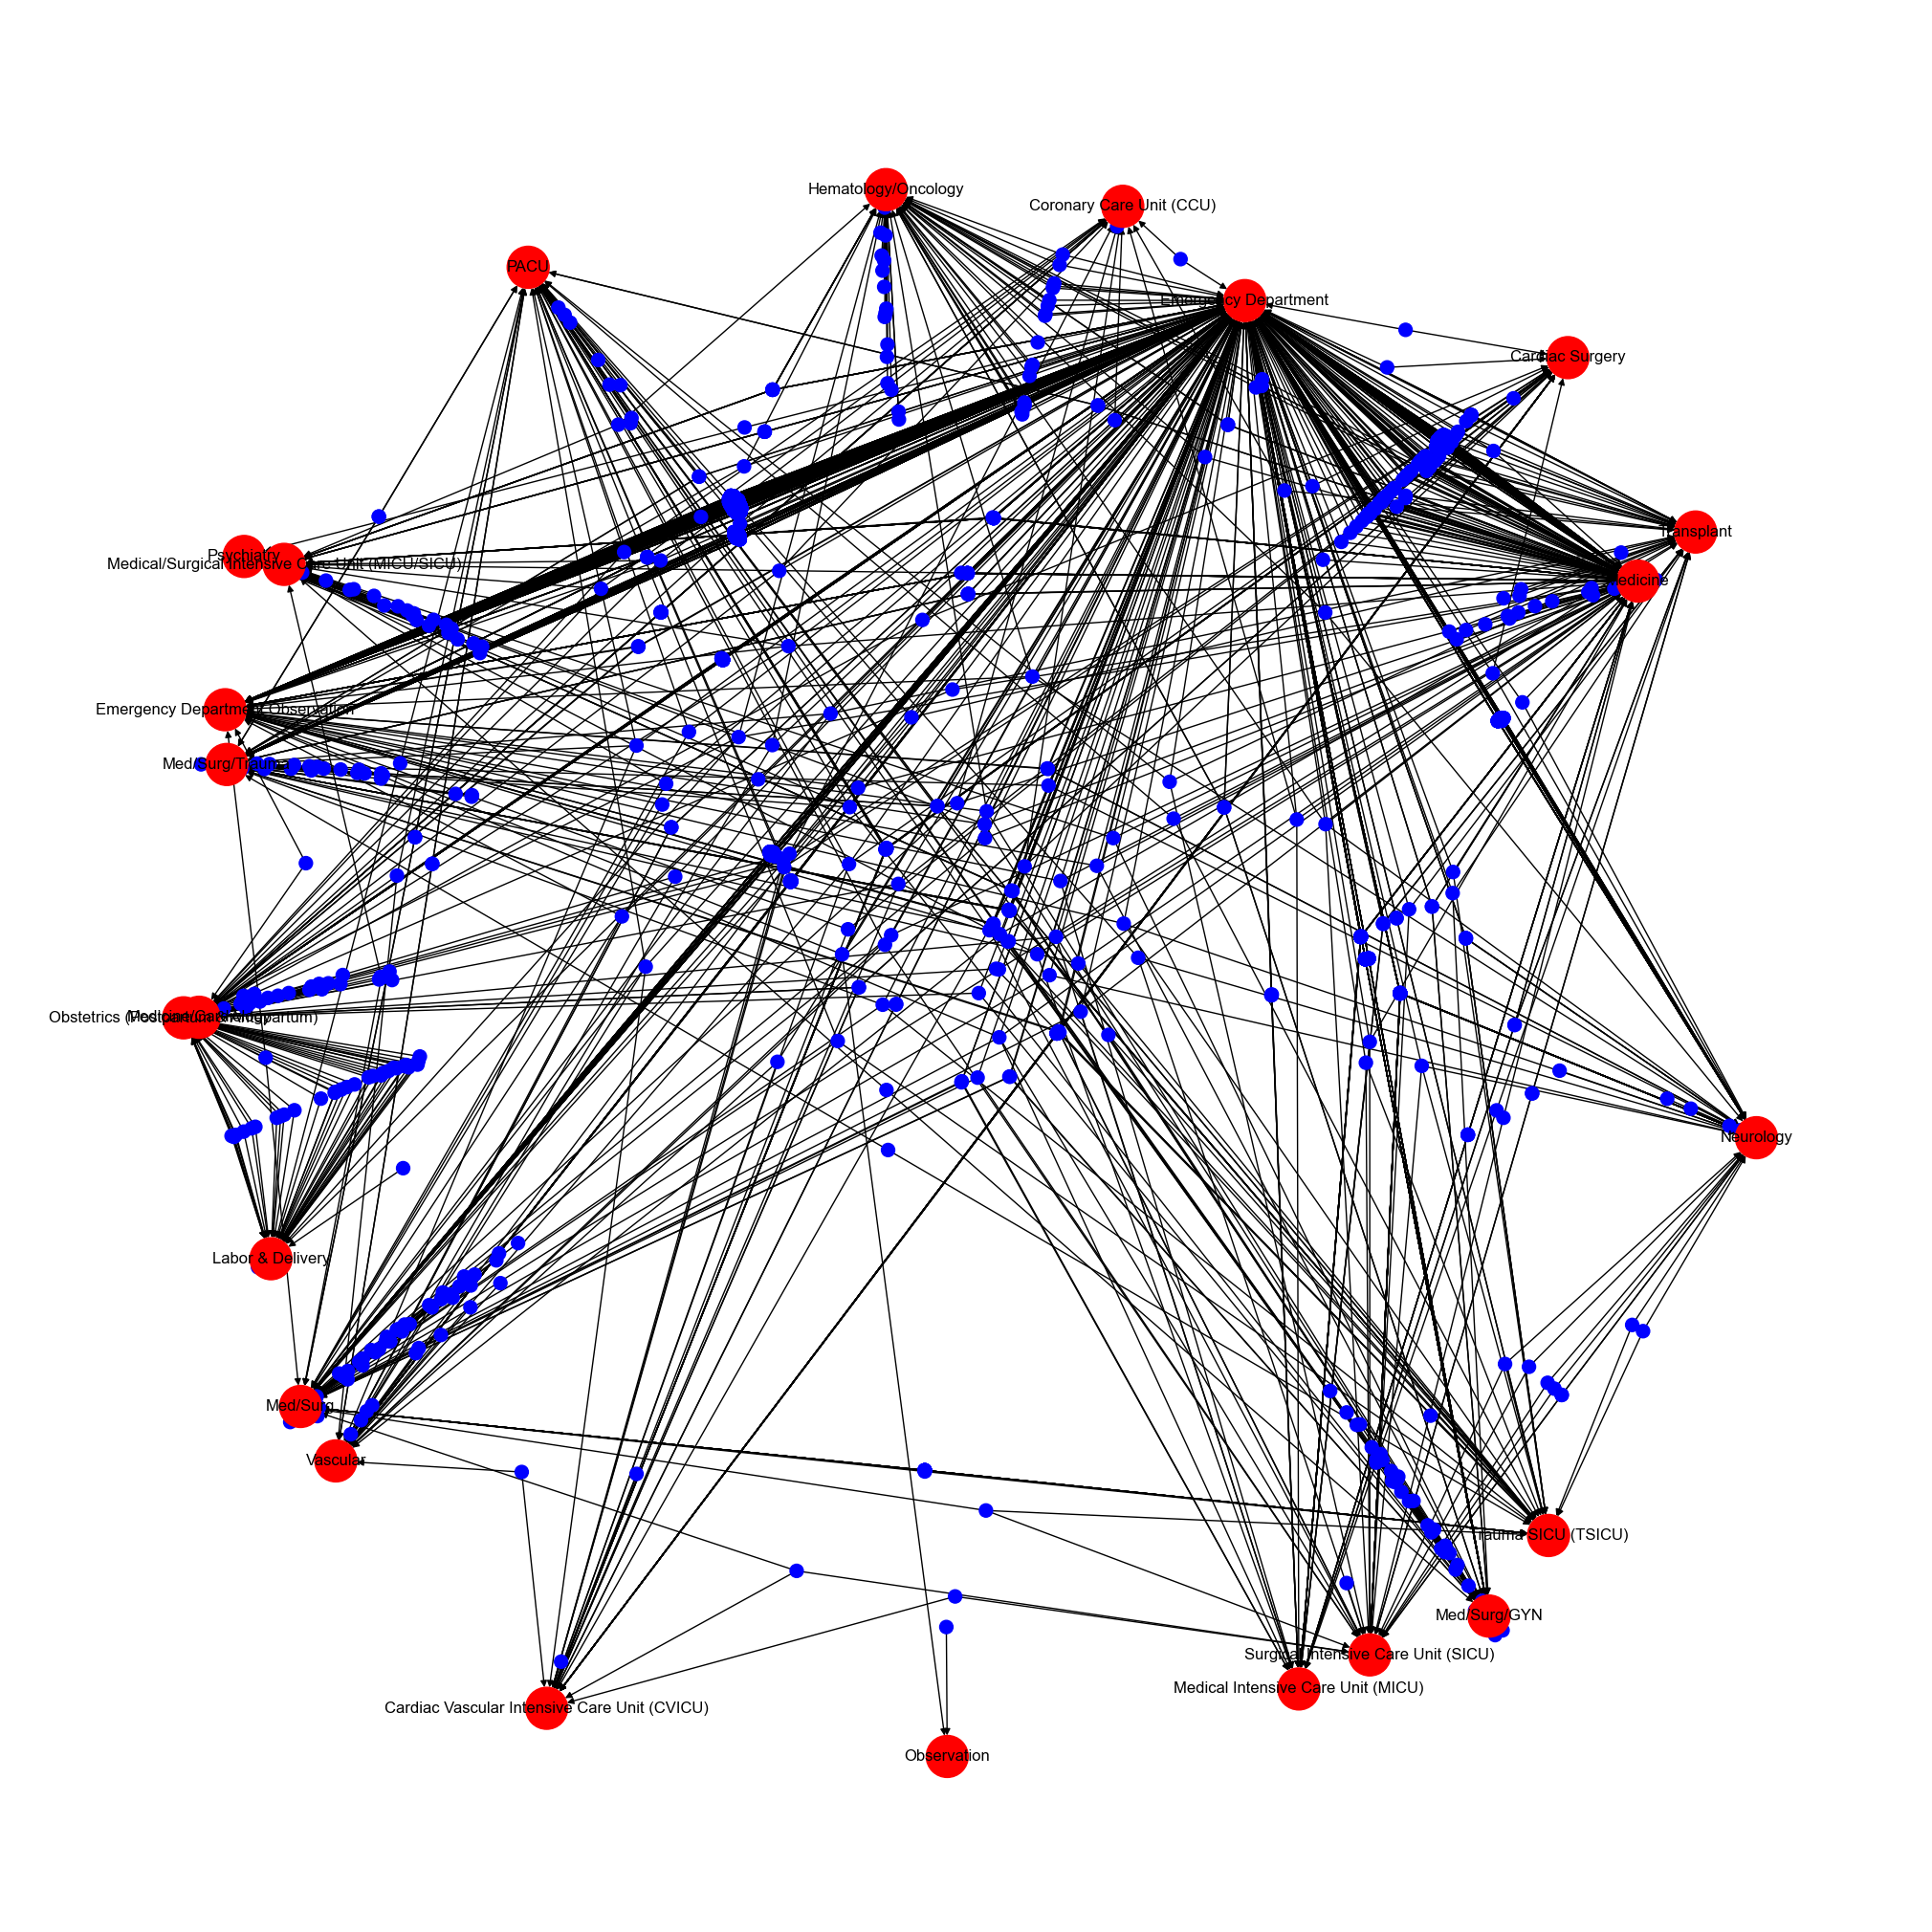

In [ ]:
def gen_graphx(size):
    sdata = data_all.up_to(np.sort(data_all['admission'].time.numpy())[size])
    dfcu = df_all[['careunit', 'mapped_careunit']].drop_duplicates()
    se = sdata['admission', 'transfer', 'careunit'].edge_index.numpy()
    dfse = pd.DataFrame({'admission': se[0], 'mapped_careunit': se[1]})
    dfse = pd.merge(dfse, dfcu, left_on='mapped_careunit', right_on='mapped_careunit', how='left')

    sg = nx.DiGraph()
    sg.add_nodes_from(dfse.admission.unique(), size=10, color='blue')
    sg.add_nodes_from(dfse.careunit.unique(), size=20, color='red')
    sg.add_edges_from(dfse[['admission', 'careunit']].values)
    return dfse, sg

def draw_graphx():
    dfgx, g = gen_graphx(1000)
    node_colors = ['blue' for i in dfgx.admission.unique()] + ['red' for i in dfgx.careunit.unique()]
    node_sizes = [100 if c == 'blue' else 1000 for c in node_colors]
    node_labels = ['' for adm in dfgx.admission.unique()] + [cu for cu in dfgx.careunit.unique()]
    plt.figure(figsize=(20,20))
    nx.draw(g, with_labels=True, node_size=node_sizes, node_color=node_colors, labels=dict(zip(g.nodes, node_labels)))

draw_graphx()

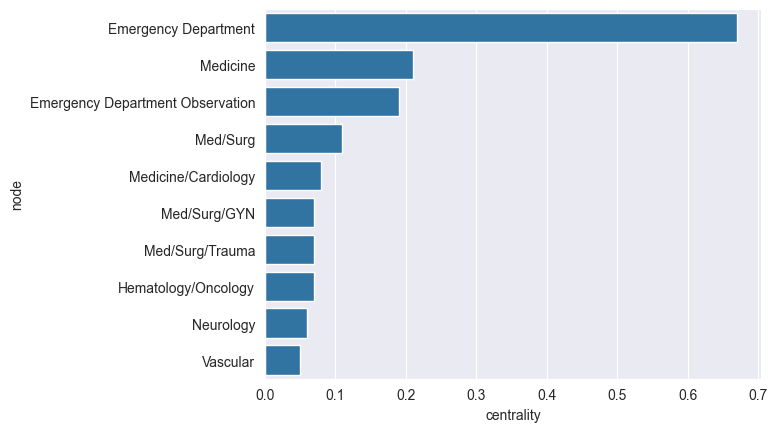

In [ ]:
def plot_centrality():
    _, g = gen_graphx(-1)
    centrality = dict(nx.degree_centrality(g))
    sorted_centrality = np.array(sorted(centrality.items(), key=lambda x:x[1], reverse=True)[: 10])
    dfc = pd.DataFrame({'node': sorted_centrality[:, :1].flatten(), 'centrality': [round(float(x), 2) for x in sorted_centrality[:, 1:].flatten()]})
    dfc['centrality'] = round(dfc['centrality'], 2)
    sns.barplot(dfc, y='node', x='centrality')

plot_centrality()

## Model Train

In [ ]:
split = int(len(data_all['admission'].node_id) * 0.9)
train_subset_dict = {'admission': data_all['admission'].node_id[:split]}
val_subset_dict = {'admission': data_all['admission'].node_id[split:]}
data_train = data_all.subgraph(train_subset_dict)
data_val = data_all.subgraph(val_subset_dict)

In [ ]:
transform = T.RandomLinkSplit(
    num_val=0.,
    num_test=0.,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('admission', 'transfer', 'careunit'),
    rev_edge_types=('careunit', 'rev_transfer', 'admission'),
)

train_data, val_data, test_data = transform(data_train)

In [ ]:
# Define seed edges:
edge_label_index = train_data['admission', 'transfer', 'careunit'].edge_label_index
edge_label = train_data['admission', 'transfer', 'careunit'].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(('admission', 'transfer', 'careunit'), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

In [ ]:
# Based on: https://medium.com/@pytorch_geometric/link-prediction-on-heterogeneous-graphs-with-pyg-6d5c29677c70

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_admission: Tensor, x_careunit: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_admission = x_admission[edge_label_index[0]]
        edge_feat_careunit = x_careunit[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_admission * edge_feat_careunit).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.admission_lin = torch.nn.Linear(data_train.num_node_features['admission'], hidden_channels)
        # embedding matrices for careunits:
        self.careunit_emb = torch.nn.Embedding(train_data["careunit"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=train_data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "admission": self.admission_lin(data["admission"].x),
          "careunit": self.careunit_emb(data["careunit"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["admission"],
            x_dict["careunit"],
            data["admission", "transfer", "careunit"].edge_label_index,
        )

        return pred


model = Model(hidden_channels=64)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 11):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["admission", "transfer", "careunit"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


100%|██████████| 519/519 [00:02<00:00, 218.13it/s]


Epoch: 001, Loss: 0.4714


100%|██████████| 519/519 [00:02<00:00, 225.61it/s]


Epoch: 002, Loss: 0.3008


100%|██████████| 519/519 [00:02<00:00, 213.37it/s]


Epoch: 003, Loss: 0.2864


100%|██████████| 519/519 [00:02<00:00, 213.04it/s]


Epoch: 004, Loss: 0.2790


100%|██████████| 519/519 [00:02<00:00, 202.34it/s]


Epoch: 005, Loss: 0.2731


100%|██████████| 519/519 [00:02<00:00, 213.00it/s]


Epoch: 006, Loss: 0.2692


100%|██████████| 519/519 [00:02<00:00, 216.27it/s]


Epoch: 007, Loss: 0.2683


100%|██████████| 519/519 [00:02<00:00, 205.08it/s]


Epoch: 008, Loss: 0.2638


100%|██████████| 519/519 [00:02<00:00, 213.43it/s]


Epoch: 009, Loss: 0.2610


100%|██████████| 519/519 [00:02<00:00, 202.11it/s]

Epoch: 010, Loss: 0.2598


In [ ]:
def predict_dataset(data_loader):
    preds = []
    ground_truths = []
    for sampled_data in tqdm.tqdm(data_loader):
        with torch.no_grad():
            sampled_data.to(device)
            preds.append(model(sampled_data))
            ground_truths.append(sampled_data["admission", "transfer", "careunit"].edge_label)

    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
    pred_binary = (pred > 0).astype(int)
    acc = accuracy_score(ground_truth, pred_binary)
    print(f"ACC: {acc:.4f}")
    pr = precision_score(ground_truth, pred_binary)
    print(f"PR: {pr:.4f}")
    rc = recall_score(ground_truth, pred_binary)
    print(f"RC: {rc:.4f}")
    auc = roc_auc_score(ground_truth, pred)
    print(f"AUC: {auc:.4f}")

    RocCurveDisplay.from_predictions(ground_truth, pred)
    plt.show()
    PrecisionRecallDisplay.from_predictions(ground_truth, pred_binary)
    plt.show()



Stats for Train:


100%|██████████| 519/519 [00:01<00:00, 416.97it/s]


ACC: 0.8916
PR: 0.8130
RC: 0.8766
AUC: 0.9540


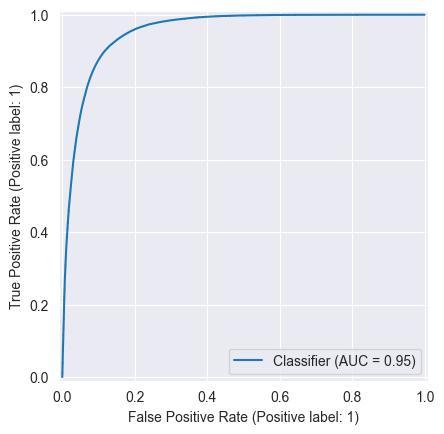

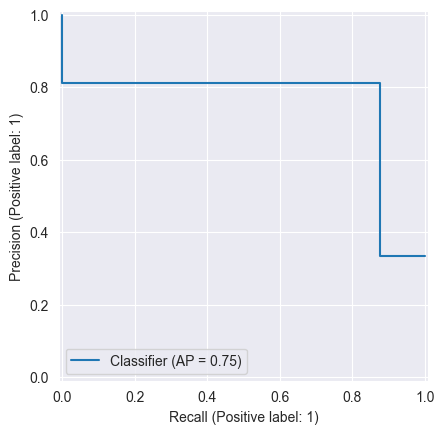

In [ ]:
print()
print('Stats for Train:')
predict_dataset(train_loader)

In [ ]:
def subgraph4test(size):
    g = data_val.subgraph({'admission': np.arange(size)})


    adm = g['admission'].node_id.numpy()
    cu = g['careunit'].node_id.numpy()
    dict_labels = dict(zip(np.arange(size), np.zeros((size, len(cu)), int)))
    for e in g['admission', 'transfer', 'careunit'].edge_index.numpy().T:
        dict_labels[e[0]][e[1]] = 1

    adm_cu = np.array([[a, c] for a in np.arange(size) for c in cu])
    g['admission', 'transfer', 'careunit'].edge_index = torch.from_numpy(adm_cu.T)
    g = T.ToUndirected()(g)
    edge_labels = np.array(list(dict_labels.values())).flatten()
    return g, edge_labels

def subgraph4admission(hadm_id):
    test_id = hadm_id
    g = data_all.subgraph({'admission': [test_id]})
    all_edges = df_all.sort_values(by='mapped_careunit').mapped_careunit.unique()
    edge_labels = np.zeros(len(all_edges))
    for e in g['admission', 'transfer', 'careunit'].edge_index.numpy()[1]:
        edge_labels[e] = 1
    g['admission', 'transfer', 'careunit'].edge_index = torch.stack([torch.from_numpy(np.zeros(len(all_edges))), torch.from_numpy(all_edges)], dim=0).to(torch.int64)
    g = T.ToUndirected()(g)
    return g, edge_labels

# gtest, test_labels = subgraph4admission(45948)
gtest, test_labels = subgraph4test(1000)


Stats for Test:


100%|██████████| 282/282 [00:01<00:00, 198.54it/s]


ACC: 0.8588
PR: 0.2231
RC: 0.5988
AUC: 0.8553


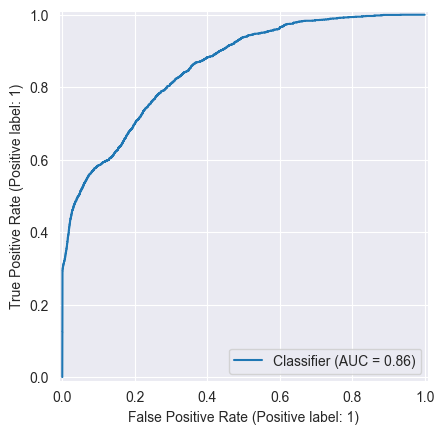

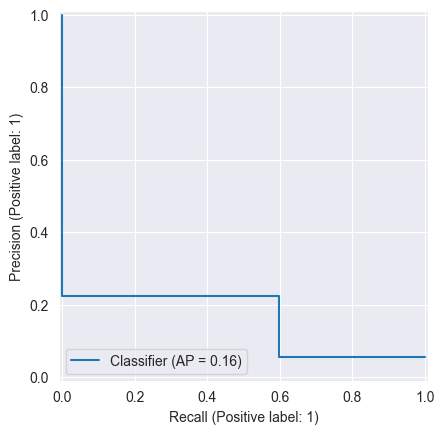

In [ ]:
test_loader = LinkNeighborLoader(
    data=gtest,
    num_neighbors=[-1],
    edge_label_index=(("admission", "transfer", "careunit"), gtest['admission', 'transfer', 'careunit'].edge_index),
    edge_label=torch.from_numpy(test_labels),
    batch_size=128,
    shuffle=False,
)

print()
print('Stats for Test:')
ret = predict_dataset(test_loader)

# Tree Classifier

In [ ]:
def df21hot():
    dft = df_all.drop(['mapped_hadm_id', 'transfertime', 'age10', 'careunit'], axis='columns').copy()
    groupby_cols = set(dft.columns) - {'mapped_careunit'}

    for cuid in dft.mapped_careunit.unique():
        dft[f'cuid_{cuid}'] = (dft.mapped_careunit == cuid).astype(int)

    dft.drop(['mapped_careunit'], axis=1, inplace=True)

    return dft.groupby(list(groupby_cols), as_index=False).max()


df_all1hot = df21hot()
df_all1hot

,anchor_age,language,admission_location,hadm_id,marital_status,gender,subject_id,insurance,admission_type,race,...,cuid_8,cuid_21,cuid_26,cuid_23,cuid_30,cuid_25,cuid_3,cuid_20,cuid_34,cuid_14
0,18,?,EMERGENCY ROOM,22807589,SINGLE,M,11155072,Medicaid,EW EMER.,HISPANIC/LATINO - DOMINICAN,...,0,0,0,0,0,0,0,0,0,0
1,18,?,EMERGENCY ROOM,23629251,SINGLE,F,17514117,Other,EW EMER.,BLACK/CAPE VERDEAN,...,0,0,0,0,0,0,0,0,0,0
2,18,?,EMERGENCY ROOM,24735550,SINGLE,M,13431697,Medicaid,EW EMER.,HISPANIC OR LATINO,...,0,0,0,0,0,0,0,0,0,0
3,18,?,EMERGENCY ROOM,28940207,SINGLE,F,10129167,Medicaid,EW EMER.,HISPANIC/LATINO - PUERTO RICAN,...,0,0,0,0,0,0,0,0,0,0
4,18,?,PHYSICIAN REFERRAL,24196854,SINGLE,F,16825661,Medicaid,URGENT,BLACK/CAPE VERDEAN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97839,91,ENGLISH,WALK-IN/SELF REFERRAL,27431066,WIDOWED,F,18268875,Other,OBSERVATION ADMIT,WHITE,...,0,0,0,0,0,0,0,0,0,0
97840,91,ENGLISH,WALK-IN/SELF REFERRAL,28081037,WIDOWED,F,11838364,Medicare,OBSERVATION ADMIT,WHITE,...,0,0,0,0,0,0,0,0,0,0
97841,91,ENGLISH,WALK-IN/SELF REFERRAL,29209400,DIVORCED,F,16179274,Medicare,EU OBSERVATION,WHITE,...,0,0,0,0,0,0,0,0,0,0
97842,91,ENGLISH,WALK-IN/SELF REFERRAL,29307519,WIDOWED,F,19711017,Medicare,EW EMER.,WHITE,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_all1hot.to_csv(f'{DATA_PATH}/df_all1hot.csv', index=False)

In [ ]:
def analyze_clf(data):
    df = pd.read_csv(f'{DATA_PATH}/{data}_data.csv')
    cols = [f'cuid_{i}' for i in range(36)]
    ground_truth = df[cols].values.flatten()
    prob = np.loadtxt(f'{DATA_PATH}/proba_{data}.csv', delimiter=',').flatten()
    pred = np.round(prob)

    acc = accuracy_score(ground_truth, pred)
    auc = roc_auc_score(ground_truth, prob)
    pr = precision_score(ground_truth, pred)
    rc = recall_score(ground_truth, pred)
    RocCurveDisplay.from_predictions(ground_truth, prob)
    plt.show()
    PrecisionRecallDisplay.from_predictions(ground_truth, pred)
    plt.show()
    return acc, auc, pr, rc


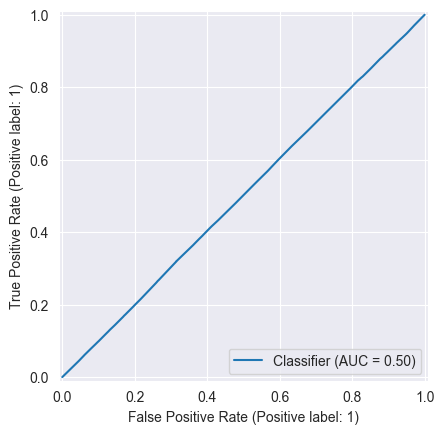

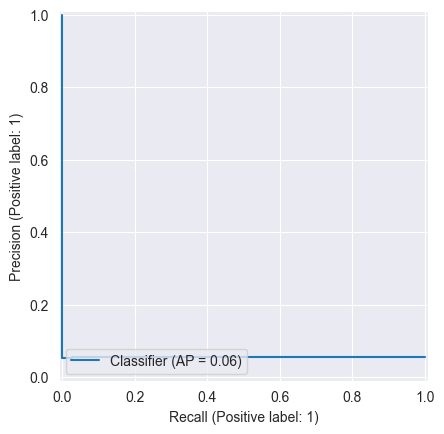

(0.9204945926405402,
 0.501304736373568,
 0.05393381390811981,
 0.025609453017329024)

In [ ]:
analyze_clf('train')

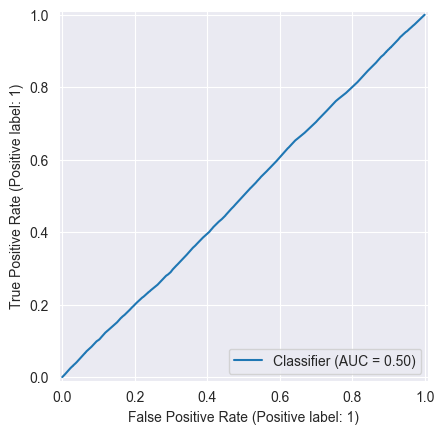

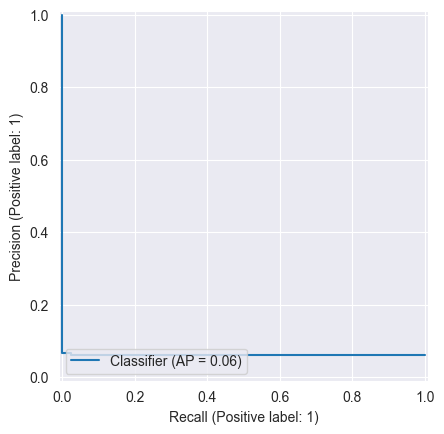

(0.9184210526315789,
 0.5010298102356565,
 0.06763892381191854,
 0.02461228784482364)

In [ ]:
analyze_clf('test')